In [54]:
from src.dataset._dataset_utils import create_datasets


ds_names = ['atnf', 'biaf', 'bivi', 'cycc', 'vtak']

SEQ_LEN = 30
LOG_SPLITS = False
FIXED_SCALING = [(7, 3000.), (8, 12.), (9, 31.)]
ROOT = './data/clean'

datasets = { x: create_datasets(x, ROOT, FIXED_SCALING, LOG_SPLITS, seq_len=SEQ_LEN) for x in ds_names }

In [55]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
LR = 1e-5
BETAS = (0.9, 0.99)
EPS = 1e-7
WEIGHT_DECAY=0

GAMMA = 0.1
STEP_SIZE = 0.1
MILESTONES = [5, 10, 15]
MIN_LR = 1e-15
CRITERION_GAMMA=1.0

OPTIMIZER = 'adam' # 'adam' or 'sgd'
SCHEDULER = 'plateau' # 'plateau', 'step', or 'multi'
CRITERION = 'ce'   # 'ce' or 'cb_focal'

BATCH_SIZE = 32
HIDDEN_SIZE = 128

EPOCHS = 300

data='atnf'

for set in ds_names:
  ds_train, ds_valid, ds_test = datasets[set]
  print(datasets[set][0][0][0].shape)

input_size = datasets[data][0][0][0].shape[1]
train_label_ct = datasets[data][0].target_counts
add_loss_to_scheduler = SCHEDULER == 'plateau'


torch.Size([30, 22])
torch.Size([30, 22])
torch.Size([30, 22])
torch.Size([30, 22])
torch.Size([30, 22])


In [57]:
%load_ext autoreload
%autoreload 2

from src.models.lnn import LNN
from torch.utils.data import DataLoader

from training_tools.utils import get_criterion, get_optimizer, get_scheduler


model = LNN(BATCH_SIZE, input_size, HIDDEN_SIZE, 3, n_layers=7, eps=EPS, activation='leaky_relu', device=device).to(device)
optimizer = get_optimizer(OPTIMIZER, model, LR, config={ 'betas': BETAS, 'eps': EPS, 'weight_decay': WEIGHT_DECAY, 'amsgrad': True })
scheduler = get_scheduler(SCHEDULER, optimizer, config={'min_lr': MIN_LR})
criterion = get_criterion(CRITERION, train_label_ct, {'cbf_gamma': CRITERION_GAMMA, 'cbf_beta': 0.9}, device)

ds_train, ds_valid, ds_test = datasets[data]

train_loader, valid_loader, test_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True), DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False), DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(log_dir=f"../data/tensorboard/testing")

from training_tools import train, evaluate

train_losses = np.zeros(EPOCHS)
valid_losses = np.zeros(EPOCHS)

#pb = tqdm(total=EPOCHS, desc="Epochs")
#pb.clear()
#pb.reset()
for epoch in range(EPOCHS):
  train_loss, train_loss_avg = train(model, train_loader, optimizer, criterion, device, epoch, writer=None)
  if add_loss_to_scheduler:
      scheduler.step(train_loss)
  else:
      scheduler.step()

  _, valid_loss_avg, _, _, v_pred_dist, _ = evaluate(model, valid_loader, criterion, device=device)

  train_losses[epoch] = train_loss_avg
  valid_losses[epoch] = valid_loss_avg

  writer.add_scalar('Loss/train', train_loss_avg, epoch)
  writer.add_scalar('Loss/valid', valid_loss_avg, epoch)

  pred_string = ' - '.join([f'C{ix} {x:.3f}' for ix, x in enumerate(v_pred_dist)])
  #pb.set_description(
  #  f'E: {epoch + 1} | Train: {train_loss_avg:.4f} | Valid {valid_loss_avg:.4f} | V_Pred Dist: {pred_string}'
  #)
  #pb.update(1)
  print(f'E: {epoch + 1} | Train: {train_loss_avg:.4f} | Valid {valid_loss_avg:.4f} | V_Pred Dist: {pred_string}')
  parms = model.parameters()
  test = parms

test_loss, test_loss_avg, test_acc, test_f1, test_pred_dist, test_mcc = evaluate(
    model,
    test_loader,
    criterion,
    device=device,
)
writer.add_scalar("Loss/test", test_loss_avg, EPOCHS)
writer.add_scalar("Accuracy/test", test_acc, EPOCHS)
writer.add_scalar("F1/test", test_f1, EPOCHS)
writer.add_scalar("MCC/test", test_mcc, EPOCHS)


E: 1 | Train: 1.1044 | Valid 1.0961 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 2 | Train: 1.1004 | Valid 1.0992 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 3 | Train: 1.0989 | Valid 1.0969 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 4 | Train: 1.0964 | Valid 1.0979 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 5 | Train: 1.0969 | Valid 1.1014 | V_Pred Dist: C0 0.000 - C1 1.000 - C2 0.000
E: 6 | Train: 1.0942 | Valid 1.0989 | V_Pred Dist: C0 0.000 - C1 0.957 - C2 0.043
E: 7 | Train: 1.0960 | Valid 1.0980 | V_Pred Dist: C0 0.000 - C1 0.838 - C2 0.162
E: 8 | Train: 1.0945 | Valid 1.1063 | V_Pred Dist: C0 0.000 - C1 1.000 - C2 0.000
E: 9 | Train: 1.0941 | Valid 1.0959 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 10 | Train: 1.0914 | Valid 1.0983 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 11 | Train: 1.0944 | Valid 1.0969 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 12 | Train: 1.0906 | Valid 1.1005 | V_Pred Dist: C0 0.043 - C1 0.957 - C2 0.000
E: 13 | Train

KeyboardInterrupt: 

| Dataset  | 0: Sell | 1: Hold | 2: Buy |
|----------|---------|---------|--------|
| Test     |    1.00 |    0.00 |   0.00 |
|----------|---------|---------|--------|
0.5121228448275862


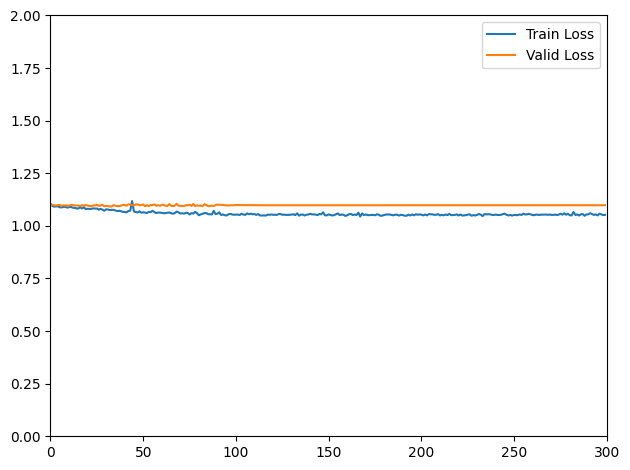

In [ ]:
from src.dataset._dataset_utils import print_target_distribution
from training_tools import plot_results

print_target_distribution([("Test", test_pred_dist)])

print(test_acc)

plot_results(train_losses, valid_losses, EPOCHS)
